In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from tabulate import tabulate
from itertools import product

# Modelos de Machine Learning
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Model Selection y Validación
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)

# Métricas
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
)


In [22]:
data = pd.read_csv("../data/Propensity.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Eliminacion de valores nulos

In [23]:
data.isnull().sum()

CODE                   0
PRODUCTO               0
TIPO_CARROCERIA        0
COMBUSTIBLE            0
Potencia               0
TRANS                  0
FORMA_PAGO             0
ESTADO_CIVIL         890
GENERO               860
OcupaciOn              0
PROVINCIA              0
Campanna1              0
Campanna2              0
Campanna3              0
Zona_Renta         13178
REV_Garantia           0
Averia_grave           1
QUEJA_CAC              0
COSTE_VENTA            0
km_anno                0
Mas_1_coche            0
Revisiones             0
Edad_Cliente           0
Tiempo                 0
dtype: int64

In [12]:
# Reemplazar "NO DATA" con la moda de la columna correspondiente
for col in data.columns:
    if data[col].dtype == 'object':  # Para columnas de tipo texto
        moda = data[col].mode()[0]  # Obtener la moda de la columna
        data[col].replace("NO DATA", moda, inplace=True)
    else:
        # Para columnas numéricas, no hacemos nada con el "NO DATA"
        pass


C:\Users\AulaDigital\AppData\Local\Temp\ipykernel_424\1568174208.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].replace("NO DATA", moda, inplace=True)


In [13]:

# Crear el objeto LabelEncoder
le = LabelEncoder()

# Convertir las columnas de tipo 'object' a valores numéricos con LabelEncoder
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col])

# Verificar los cambios
print(data.head())


    CODE  PRODUCTO  TIPO_CARROCERIA  COMBUSTIBLE  Potencia  TRANS  FORMA_PAGO  ESTADO_CIVIL  GENERO  OcupaciOn  PROVINCIA  Campanna1  Campanna2  Campanna3  Zona_Renta  REV_Garantia  Averia_grave  QUEJA_CAC  COSTE_VENTA  km_anno  Mas_1_coche  Revisiones  Edad_Cliente  Tiempo
0      0         0                0            0         1      1           0             0       1          1          4          1          0          0           2             0             2          1         2892        0        False           2            18       0
1  11111         0                0            0         1      1           0             0       0          1         47          0          0          0           2             1             3          0         1376     7187        False           2            53       0
2  22222         0                0            0         1      1           3             0       1          1         30          0          0          0           1         

In [14]:
# Verificar si hay filas duplicadas
duplicates = data.duplicated().sum()
print(f"Filas duplicadas: {duplicates}")

# Eliminar duplicados si los hay
data = data.drop_duplicates()


Filas duplicadas: 0


In [15]:
# Verificar valores nulos
missing_values = data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

# Si hay valores faltantes, podemos imputarlos (por ejemplo, con la moda, media o median)
# En este caso, rellenamos los valores nulos con la moda de cada columna
for col in data.columns:
    if data[col].isnull().sum() > 0:
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)

# Verificar nuevamente si hay valores nulos
missing_values_after_imputation = data.isnull().sum()
print("Valores faltantes después de la imputación:")
print(missing_values_after_imputation)


Valores faltantes por columna:
CODE               0
PRODUCTO           0
TIPO_CARROCERIA    0
COMBUSTIBLE        0
Potencia           0
TRANS              0
FORMA_PAGO         0
ESTADO_CIVIL       0
GENERO             0
OcupaciOn          0
PROVINCIA          0
Campanna1          0
Campanna2          0
Campanna3          0
Zona_Renta         0
REV_Garantia       0
Averia_grave       0
QUEJA_CAC          0
COSTE_VENTA        0
km_anno            0
Mas_1_coche        0
Revisiones         0
Edad_Cliente       0
Tiempo             0
dtype: int64
Valores faltantes después de la imputación:
CODE               0
PRODUCTO           0
TIPO_CARROCERIA    0
COMBUSTIBLE        0
Potencia           0
TRANS              0
FORMA_PAGO         0
ESTADO_CIVIL       0
GENERO             0
OcupaciOn          0
PROVINCIA          0
Campanna1          0
Campanna2          0
Campanna3          0
Zona_Renta         0
REV_Garantia       0
Averia_grave       0
QUEJA_CAC          0
COSTE_VENTA        0
km_anno  

In [16]:
# Función para detectar y eliminar valores atípicos usando IQR (Rango intercuartílico)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.15)
    Q3 = df[col].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Detectar y eliminar outliers para las columnas numéricas
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data = remove_outliers(data, col)

# Ver los datos después de eliminar los outliers
print("Datos después de eliminar outliers:")
print(data.describe())


Datos después de eliminar outliers:
               CODE      PRODUCTO  TIPO_CARROCERIA   COMBUSTIBLE      Potencia    TRANS    FORMA_PAGO  ESTADO_CIVIL        GENERO  OcupaciOn     PROVINCIA     Campanna1  Campanna2  Campanna3    Zona_Renta  REV_Garantia  Averia_grave     QUEJA_CAC   COSTE_VENTA       km_anno    Revisiones  Edad_Cliente        Tiempo
count  36923.000000  36923.000000     36923.000000  36923.000000  36923.000000  36923.0  36923.000000  36923.000000  36923.000000    36923.0  36923.000000  36923.000000    36923.0    36923.0  36923.000000  36923.000000  36923.000000  36923.000000  36923.000000  36923.000000  36923.000000  36923.000000  36923.000000
mean   27658.497251      3.320397         2.833139      0.561276      1.551039      1.0      1.039623      0.772472      0.719741        1.0     25.558432      0.356769        0.0        0.0      1.460282      0.518809      2.161742      0.400347   2482.210248  12679.967798      3.990033     47.496141      1.855510
std    16693.

In [17]:
# Verificar tipos de datos
print("Tipos de datos actuales:")
print(data.dtypes)

# Convertir las columnas que deberían ser numéricas, si es necesario
data['km_anno'] = pd.to_numeric(data['km_anno'], errors='coerce')
data['COSTE_VENTA'] = pd.to_numeric(data['COSTE_VENTA'], errors='coerce')

# Verificar nuevamente
print("Tipos de datos después de la conversión:")
print(data.dtypes)


Tipos de datos actuales:
CODE               int64
PRODUCTO           int64
TIPO_CARROCERIA    int64
COMBUSTIBLE        int64
Potencia           int64
TRANS              int64
FORMA_PAGO         int64
ESTADO_CIVIL       int64
GENERO             int64
OcupaciOn          int64
PROVINCIA          int64
Campanna1          int64
Campanna2          int64
Campanna3          int64
Zona_Renta         int64
REV_Garantia       int64
Averia_grave       int64
QUEJA_CAC          int64
COSTE_VENTA        int64
km_anno            int64
Mas_1_coche         bool
Revisiones         int64
Edad_Cliente       int64
Tiempo             int64
dtype: object
Tipos de datos después de la conversión:
CODE               int64
PRODUCTO           int64
TIPO_CARROCERIA    int64
COMBUSTIBLE        int64
Potencia           int64
TRANS              int64
FORMA_PAGO         int64
ESTADO_CIVIL       int64
GENERO             int64
OcupaciOn          int64
PROVINCIA          int64
Campanna1          int64
Campanna2          i

In [18]:
# Convertir la columna 'Mas_1_coche' a valores 0 y 1
data['Mas_1_coche'] = data['Mas_1_coche'].astype(int)

# Verificar la conversión
print(data['Mas_1_coche'].head())


0    0
1    0
2    1
3    1
5    0
Name: Mas_1_coche, dtype: int64


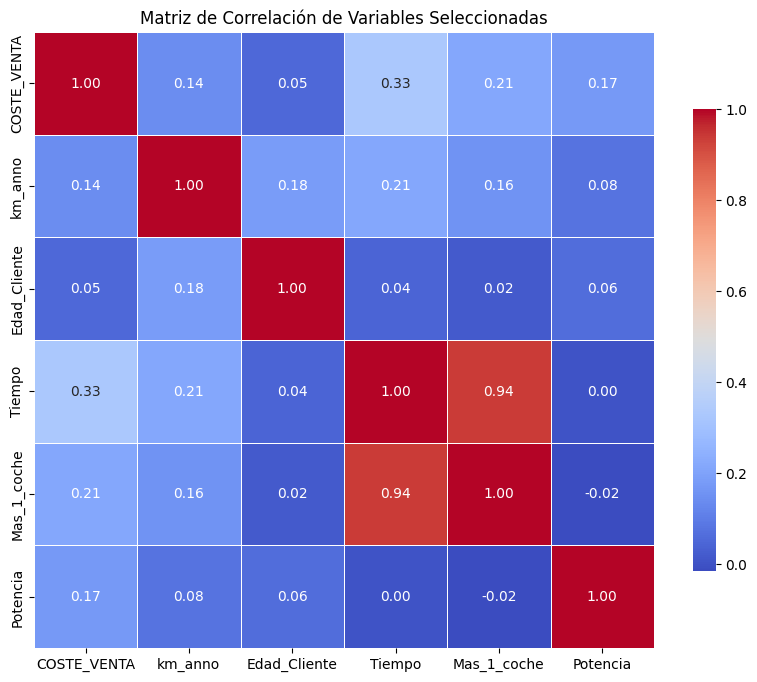

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selección de las columnas numéricas importantes
columns_of_interest = ['COSTE_VENTA', 'km_anno', 'Edad_Cliente', 'Tiempo', 'Mas_1_coche', 'Potencia']

# Filtrar solo las columnas seleccionadas
data_of_interest = data[columns_of_interest]

# Calcular la matriz de correlación
correlation_matrix = data_of_interest.corr()

# Mostrar la matriz de correlación como un heatmap (mapa de calor)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.75})
plt.title("Matriz de Correlación de Variables Seleccionadas")
plt.show()
